### Student Information
Name: leo lin

Student ID: 109003814

GitHub ID: leolin65

Kaggle name: leolin65

Kaggle private scoreboard snapshot:

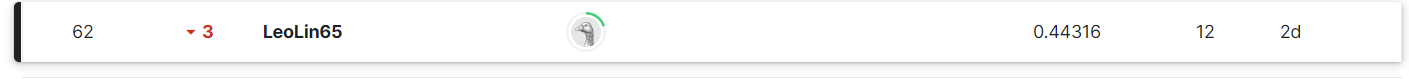

---

### Instructions

## 1. Data Preparation

## 1.1 Load data

1. data_identification: define which twitter ID are train and which one are test data(csv)
2. emotion: Label(Emotion) for train data(csv)
3. tweets_DM: data contain score, date hashtag, tweetid and text data from twitter(json)

In [13]:
#import dataframe package
import pandas as pd
pd.set_option('max_colwidth', 400)

In [14]:
#NLTK (Natural Language Toolkit) is the go-to API for NLP (Natural Language Processing) with Python. 
#It is a really powerful tool to preprocess text data for further analysis like with ML models for instance. 
#It helps convert text into numbers, which the model can then easily work with. 

#import NLTK API
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from functools import partial



In [15]:
#Read and Load data set
data_identification = pd.read_csv("data_identification.csv")


In [16]:
#look the data_identification: train or test
print(data_identification)

         tweet_id identification
0        0x28cc61           test
1        0x29e452          train
2        0x2b3819          train
3        0x2db41f           test
4        0x2a2acc          train
...           ...            ...
1867530  0x227e25          train
1867531  0x293813          train
1867532  0x1e1a7e          train
1867533  0x2156a5          train
1867534  0x2bb9d2          train

[1867535 rows x 2 columns]


In [17]:
#Load  taining data set (emotion) 
emotion = pd.read_csv("emotion.csv")

In [18]:
#look the emotion: 8 classes
print(emotion)

         tweet_id       emotion
0        0x3140b1       sadness
1        0x368b73       disgust
2        0x296183  anticipation
3        0x2bd6e1           joy
4        0x2ee1dd  anticipation
...           ...           ...
1455558  0x38dba0           joy
1455559  0x300ea2           joy
1455560  0x360b99          fear
1455561  0x22eecf           joy
1455562  0x2fb282  anticipation

[1455563 rows x 2 columns]


for json data we need to normalize (split it into seperate columns)

In [19]:
#import json API
import json
#Read and Load json files
tweets_DM = pd.read_json (r'tweets_DM.json',lines=True,orient='columns')

#normalize json data
data = tweets_DM['_source'].tolist()
df = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')

#concate two dataframe by column
tweets_DM= pd.concat([tweets_DM, df], axis=1)

In [20]:
#check sample data of 
print(tweets_DM)

         _score          _index  \
0           391  hashtag_tweets   
1           433  hashtag_tweets   
2           232  hashtag_tweets   
3           376  hashtag_tweets   
4           989  hashtag_tweets   
...         ...             ...   
1867530     827  hashtag_tweets   
1867531     368  hashtag_tweets   
1867532     498  hashtag_tweets   
1867533     840  hashtag_tweets   
1867534     360  hashtag_tweets   

                                                                                                                                                                                                                  _source  \
0                                                              {'tweet': {'hashtags': ['Snapchat'], 'tweet_id': '0x376b20', 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that's <LH>'}}   
1          {'tweet': {'hashtags': ['freepress', 'TrumpLegacy', 'CNN'], 'tweet_id': '0x2d5350', 'text': '@brianklaas As we see, Trump is d

In [21]:
# Compress size for saving memory space
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% Compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [22]:
#Apply down size function to compress data
tweets_DM = downcast(tweets_DM)
data_identification = downcast(data_identification)
emotion = downcast(emotion)

9.4% Compressed
0.0% Compressed
0.0% Compressed


In [23]:
## Check above result, tweets_DM already be compressed 9.4%, It is good for computation in the future.

In [25]:
data_identification

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [26]:
# column rename for easy typing
tweets_DM= tweets_DM.rename(columns={'tweet.tweet_id': 'id', 'tweet.text': 'text','tweet.hashtags':'hashtags'})
#Drop unused six columns ('_source','_index','_type','_score', '_crawldate','hashtags')
tweets_DM=tweets_DM.drop(['_source','_index','_type','_score', '_crawldate','hashtags'], axis=1)

# column rename for easy typing
data_identification= data_identification.rename(columns={'tweet_id': 'id'})
# column rename for easy typing
emotion= emotion.rename(columns={'tweet_id': 'id'})
#assign "tweets_DM" to new dataframe
Text = tweets_DM

In [27]:
#Dividing training and testing set data
traindata=data_identification[data_identification['identification']=='train']
traindata = pd.merge(traindata, Text,  how='left', left_on=['id'], right_on = ['id'])
traindata = pd.merge(traindata, emotion,  how='left', left_on=['id'], right_on = ['id'])


Testdata=data_identification[data_identification['identification']=='test']
Testdata = pd.merge(Testdata, Text,  how='left', left_on=['id'], right_on = ['id'])

print(traindata.shape)
print(Testdata.shape)

(1455563, 4)
(411972, 3)


In [28]:
print(traindata)

               id identification  \
0        0x29e452          train   
1        0x2b3819          train   
2        0x2a2acc          train   
3        0x2a8830          train   
4        0x20b21d          train   
...           ...            ...   
1455558  0x227e25          train   
1455559  0x293813          train   
1455560  0x1e1a7e          train   
1455561  0x2156a5          train   
1455562  0x2bb9d2          train   

                                                                                                                                                 text  \
0        Huge Respect🖒 @JohnnyVegasReal talking about losing his dad to cancer."if you dont remember the good times it was all for nothing"#beautiful   
1                                                             Yoooo we hit all our monthly goals with the new app in two weeks. #spateradio #app <LH>   
2                                                                   @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss W

In [29]:
print(Testdata)

              id identification  \
0       0x28cc61           test   
1       0x2db41f           test   
2       0x2466f6           test   
3       0x23f9e9           test   
4       0x1fb4e1           test   
...          ...            ...   
411967  0x2c4dc2           test   
411968  0x31be7c           test   
411969  0x1ca58e           test   
411970  0x35c8ba           test   
411971  0x1d941b           test   

                                                                                                                                             text  
0                                                               @Habbo I've seen two separate colours of the elegant furni on your homepage? <LH>  
1                                             @FoxNews @KellyannePolls No serious self respecting individual believes much less agrees w her <LH>  
2                            Looking for a new car, and it says 1 lady owner. That means needs new clutch, gearbox and brakes. #womendr

In [30]:
# shuffle training and testing dataset 
traindata = traindata.sample(frac=1)
Testdata = Testdata.sample(frac=1)
print(traindata.shape)
print(Testdata.shape)

(1455563, 4)
(411972, 3)


### 1.2 Save data

In [31]:
#save data in Pickle format to continue without doing the previous step againn.
traindata.to_pickle("traindata.pkl")
Testdata.to_pickle("Testdata.pkl")

In [32]:
#reload from saved file
import pandas as pd
traindata = pd.read_pickle("traindata.pkl")
Testdata = pd.read_pickle("Testdata.pkl")

In [33]:
#Check if there is missing values in both train and test dataset
#Use Honework1 helpers to do this.
import helpers.data_mining_helpers as dmh
traindata.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text,emotion
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0,0


In [34]:
Testdata.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


# 1.3 Text Cleaning from tweet dataset

In [35]:
#check text lenght for each tweet before text cleaning
traindata['textlen'] = [len(t) for t in traindata['text']]
Testdata['textlen'] = [len(t) for t in Testdata['text']]

#check words count for each tweet before text cleaning
traindata['word_count'] = traindata['text'].apply(lambda x: len(str(x).split(" ")))
Testdata['word_count'] = Testdata['text'].apply(lambda x: len(str(x).split(" ")))

In [36]:
traindata

,id,identification,text,emotion,textlen,word_count
430544,0x242e0e,train,<LH> night #bathtime ...nothing <LH>,joy,36,5
454777,0x2f690a,train,"@ChanceOfT this is orange juice, though!!! <LH>",trust,47,7
394666,0x33e20a,train,Liking my tweets and not following me? @Kitana_Prime <LH>,disgust,57,9
708671,0x21c86d,train,"#mexicovselsalvador let's go #ElSalvador , <LH> #Comeback ! 1-1",joy,64,10
853679,0x369ebe,train,I hope Republican Christians sitting in church this morning will hear the message of Jesus rather than the #GOP. <LH> #whoismyneighbour,joy,135,21
...,...,...,...,...,...,...
1207888,0x1eb1ef,train,The Dinkster QUITS YouTube !! | <LH> 😱,surprise,40,10
864966,0x33cdce,train,"Circle than the region at the same as the contrary quality', just as 'positives' and 'privatives' are not subject to also. <LH>",joy,127,22
1051632,0x1f8610,train,anyone else feeling super <LH> tonight?,anticipation,39,6
1275036,0x23b11e,train,So tired from all the shopping for the house today. <LH>,trust,56,11


### Create Function to clean text from tweet

Because texts from tweets is too messy so i need to do some text cleaning before applying EDA.
These are 5 steps to implement for text cleaning:

0. Replace emoticon for text
1. Replace emoji for text
2. Remove whitespace/url/mentions/hashtags/HTML/multiple letter/special letter for text
3. Lowercase for text
4. Replace contractions/slangs for text

For emoticon, contraction, and slang, I check below github and use to replace the original text(credit: https://github.com/Deffro/text-preprocessing-techniques/blob/master/techniques.py)

In [37]:
# Refer to https://github.com/Deffro/text-preprocessing-techniques/blob/master/techniques.py
# defined emoticon
def load_dict_smileys():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

In [48]:
# defined contractions/slangs
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "u":"you",
        "r":"are",
        "sux":"sucks",
        "2day":"today",
        "2nite":"tonight",
        "4u":"for you",
        "4ward":"forward",
        "a3":"anyplace, anywhere, anytime",
        "a/n":"author note",
        "a/w":"anyway",
        "a/s/l":"age, sex, location",
        "adn":"any day now",
        "afaic":"as far as i'm concerned",
        "afaik":"as far as I know",
        "afk":"away from keyboard",
        "aggro":"aggresive",
        "aight":"alright",
        "airhead":"stupid",
        "aka":"as known as",
        "alol":"actually laughing out loud",
        "amigo":"friend",
        "amz":"amazing",
        "app":"application",
        "armpit":"undesirable",
        "asap":"as soon as possible",
        "atm":"at the moment",
        "atw":"all the way",
        "b/c":"because",
        "b-day":"birthday",
        "b4":"before",
        "b4n":"bye for now",
        "bae":"before anyone else",
        "bak":"back at the keyboard",
        "bbl":"bee back later",
        "bday":"birthday",
        "becuz":"because",
        "bent":"angry",
        "bestie":"best friend",
        "besty":"best friend",
        "bf":"boyfriend",
        "bff":"best friends forever",
        "bffe":"best friends forever",
        "bfn":"bye for now",
        "bg":"big grin",
        "bmfe":"best mates forever",
        "bmfl":"best mates life",
        "bozo":"idiot",
        "brah":"friend",
        "bravo":"well done",
        "brb":"be right back",
        "bro":"brother",
        "bta":"but then again",
        "btdt":"been there, done that",
        "btr":"better",
        "btw":"by the way",
        "buddy":"friend",
        "c'mon":"came on",
        "cid crying in disgrace":"",
        "congrats congratulations":"",
        "copacetic excellent":"",
        "coz beacause":"",
        "cu":"see you",
        "cuddy":"friends",
        "cul":"see you later",
        "cul8r":"see you later ",
        "cutie":"cute",
        "cuz":"because",
        "cya":"bye",
        "cyo":"see you online ",
        "dbau":"doing business as usual",
        "deets":"details",
        "dmn":"damn",
        "dobe":"idiot",
        "dope":"stupid",
        "dork":"strange",
        "dunno":"don't know",
        "dwi":"deal with it",
        "dyd":"don't you dare",
        "ermahgerd":"oh my gosh",
        "eu":"europe",
        "ez":"easy",
        "f9":"fine",
        "fav":"favorite",
        "far-out":"great",
        "fb":"facebook",
        "flick":"movie",
        "fml":"fuck my life",
        "foxy":"sexy",
        "friggin":"freaking",
        "fttn":"for the time being",
        "ftw":"for the win",
        "fud":"fear, uncertainty, and doubt",
        "fwiw":"for what it's worth ",
        "fyi":"for your information",
        "g":"grin ",
        "g2g":"got to go ",
        "ga":"go ahead ",
        "gal":"get a life",
        "getcha":"understand ",
        "gf":"girlfriend ",
        "gfn":"gone for now",
        "gg":"good game",
        "gj":"good job",
        "gky":"go kill yourself",
        "gl":"good luck",
        "glhf":"good luck have fun",
        "gmab":"give me a break",
        "gmbo":"giggling my butt off ",
        "gmta":"great minds think alike ",
        "goof":"idiot",
        "goofy":"idiot",
        "gr8":"great",
        "gtg":"got to go",
        "gud":"good",
        "h8":"hate",
        "hagn":"have a good night ",
        "hdop":"help delete online predators ",
        "hf":"have fun",
        "hml":"hate my life",
        "hoas":"hold on a second",
        "hhis":"hanging head in shame ",
        "hmu":"hit me up",
        "hru":"how are you",
        "twt":"hope this helps",
        "hw":"homework",
        "im":"i am",
        "i'ma":"i am going to",
        "iac":"in any case ",
        "ic":"I see ",
        "icymi":"in case you missed it",
        "idk":"I don't know",
        "iggy":"ignore ",
        "iht":"i hate this",
        "ikr":"i know, right?",
        "ilt":"i like that",
        "ily":"i love you",
        "ima":"i am going to ",
        "imao":"in my arrogant opinion",
        "imnsho":"in my not so humble opinion ",
        "imo":"in my opinion ",
        "imy":"i miss you",
        "iou":"i owe you",
        "iow":"in other words ",
        "ipn":"I’m posting naked ",
        "irl":"in real life ",
        "j/k":"just kidding",
        "jdi":"just do it",
        "jk":"just kidding",
        "jkn":"joking",
        "jyeah":"yeah",
        "kinda":"kind of",
        "l8":"late",
        "l8r":"later",
        "lbh":"let's be honest",
        "ld":"later, dude",
        "ldi":"let's do it  ",
        "ldr":"long distance relationship ",
        "lees":"beautiful ",
        "lfm":"looking for more",
        "lil":"little",
        "llta":"lots and lots of thunderous applause ",
        "lmao":"laugh my ass off",
        "lmirl":"let's meet in real life ",
        "lmk":"let me know",
        "lol":"laugh out loud",
        "lolz":"laugh out loud",
        "lotta":"lot of",
        "lsr":"loser",
        "ltr":"longterm relationship",
        "lua":"love you always ",
        "lub":"love",
        "lubb":"love",
        "lulab":"love you like a brother ",
        "lulas":"love you like a sister ",
        "lul":"laugh",
        "luls":"laugh",
        "lulz":"laugh",
        "lumu":"love you miss you",
        "luv":"love",
        "lux":"luxury",
        "lwm":"laugh with me",
        "lwp":"laugh with passion",
        "lvl":"level",
        "m/f":"male or female",
        "m2":"me too",
        "m8":"mate",
        "me2":"me too",
        "milf":"mother I would like to fuck",
        "mma":"meet me at",
        "mmb":"message me back",
        "mvp":"most valueable player",
        "msg":"message",
        "mtf":"more to follow",
        "myob":"mind your own business",
        "nah":"no",
        "nc":"no comment",
        "nk":"not kidding",
        "ngl":"not gonna lie",
        "nlt":"no later than",
        "nm":"not much",
        "no1":"no one",
        "np":"no problem",
        "nsfw":"not safe for work",
        "nuh":"no",
        "nvm":"nevermind",
        "obo":"or best offer",
        "oic":"oh, i see",
        "oll":"online love ",
        "omg":"oh my god",
        "omw":"on my way",
        "osm":"awesome",
        "otoh":"on the other hand ",
        "perv":"pervert",
        "pervy":"pervert",
        "phat":"pretty hot and tempting",
        "pir":"parent in room",
        "pls":"please",
        "plz":"please",
        "ppl":"people",
        "pro":"professional",
        "pwnd":"owned",
        "qq":"crying",
        "r":"are",
        "rly":"really",
        "rofl":"roll on the floor laughing",
        "rolf":"roll on the floor laughing",
        "rpg":"role playing games",
        "ru":"are you",
        "s2u":"shame to you",
        "scrub":"loser",
        "sec":"second",
        "shid":"slaps head in disgust",
        "shoulda":"should have",
        "sff":"so funny",
        "smexy":"smart and sexy",
        "smh":"shaking my head",
        "somy":"sick of me yet",
        "sot":"short of time ",
        "sry":"sorry",
        "str8":"straight",
        "sux":"sucks",
        "swag":"style",
        "taze":"irritate",
        "tba":"to be announced",
        "tbfu":"too bad for you",
        "tbc":"to be continued",
        "tbd":"to be determined",
        "tbr":"to be rude",
        "tc":"take care",
        "thx":"thanks",
        "thanx":"thanks",
        "thx":"thanks",
        "tfw":"that feeling  when",
        "til":"today i learned",
        "ttyl":"talk to you later ",
        "ty":"thank you",
        "tyvm":"thank you very much",
        "u":"you",
        "uber":"the best",
        "ugh":"disgusted",
        "ur":"you are",
        "uw":"you are welcome ",
        "vs":"versus",
        "w2f":"way too funny",
        "w8":"wait",
        "wak":"weird",
        "wanna":"want to",
        "wb":"welcome back",
        "whiz":"talented",
        "whoa":"surprise",
        "whoah":"surprise",
        "wfm":"works for me ",
        "wibni":"wouldn't it be nice if ",
        "wmd":"weapon of mass destruction",
        "wot":"what",
        "wtf":"what the fuck",
        "wtg":"way to go",
        "wtgp":"want to go private",
        "wu":"what's up",
        "wuh":"what?",
        "wuv":"love",
        "ym":"young man",
        "yawn":"boring",
        "yum":"good",
        "x":"kiss",
        "xxx":"kiss",
        "xdd":"laughing",
        "y":"why",
        "yolo":"you only live once",
        "yuge":"huge",
        "yw":"you are welcome",
        "ywa":"you are welcome anyway",
        "zomg":"oh my god!",
        "zzz":"sleeping"    
        }

In [49]:
#replace emoticon with words in the dictionary
emoticon=load_dict_smileys()

def demoticon(text):
    text = text.replace("’","'")
    words = text.split()
    text = [emoticon[text] if text in emoticon else text for text in words]
    text = " ".join(text)
    return text

In [50]:
#https://pypi.org/project/emoji/
#if happened ImportError: cannot import name 'UNICODE_EMOJI' from 'emoji', reinstall below.
#pip uninstall emoji
#https://anaconda.org/conda-forge/emoji
#conda install -c conda-forge emoji==1.6.3

import emoji
from emoji import emojize
# add space before and after the emoji
from emoji import UNICODE_EMOJI
def is_emoji(s, language="en"):
    return s in UNICODE_EMOJI[language]
    
def add_space(text):
    return ''.join(' ' + char + ' 'if is_emoji(char) else char for char in text).strip()

In [51]:
#replace emoji using emoji library
def demoji(text):
    text = emoji.demojize(text, delimiters=("", " "))  
    return text

In [52]:
#clean noisy data
import re
import itertools
def cleaning_text(text):    
    text = text.strip() # remove white space
    text = re.sub(r'http\S+', "", text)    # remove urls
    text = re.sub(r'@\w+','',text)         # remove mentions
    text = re.sub(r'#', '', text)       # remove hastags \w+
    text = re.sub(r'<\w+','', text)       # remove html tags
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text) 
    text = re.sub(r'>', '', text)
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) # remove multiple letters
    text = text.lower()  #convert to lower case
    text = re.sub('[!,*)@#%(&$_?.^+->:;/\"]', '', text)
    return text

In [53]:
#replace the contractions
CONTRACTIONS=load_dict_contractions()
def replaceconslang(text):
    text = text.replace("’","'")
    words = text.split()
    text = [CONTRACTIONS[text] if text in CONTRACTIONS else text for text in words]
    text = " ".join(text)
    text =re.sub('[^a-zA-Z0-9 \n\.]', '', text)
    return text

In [55]:
#Apply above function to dataframe & insert into new column
##%%time
traindata['cleantext']=traindata['text'].apply(lambda x: demoticon(x))
Testdata['cleantext']=Testdata['text'].apply(lambda x: demoticon(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: add_space(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: add_space(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: demoji(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: demoji(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: cleaning_text(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: cleaning_text(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: replaceconslang(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: replaceconslang(x))

In [56]:
#Apply length function
traindata['textlenafter']=[len(t) for t in traindata['cleantext']]

#split by blank
traindata['word_countafter'] = traindata['cleantext'].apply(lambda x: len(str(x).split(" ")))

In [57]:
traindata

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter
430544,0x242e0e,train,<LH> night #bathtime ...nothing <LH>,joy,36,5,night bathtime nothing,22,3
454777,0x2f690a,train,"@ChanceOfT this is orange juice, though!!! <LH>",trust,47,7,this is orange juice though,27,5
394666,0x33e20a,train,Liking my tweets and not following me? @Kitana_Prime <LH>,disgust,57,9,liking my tweets and not following me,37,7
708671,0x21c86d,train,"#mexicovselsalvador let's go #ElSalvador , <LH> #Comeback ! 1-1",joy,64,10,mexicovselsalvador let us go elsalvador comeback,48,6
853679,0x369ebe,train,I hope Republican Christians sitting in church this morning will hear the message of Jesus rather than the #GOP. <LH> #whoismyneighbour,joy,135,21,i hope republican christians sitting in church this morning will hear the message of jesus rather than the gop whoismyneighbour,127,20
...,...,...,...,...,...,...,...,...,...
1207888,0x1eb1ef,train,The Dinkster QUITS YouTube !! | <LH> 😱,surprise,40,10,the dinkster quits youtube facescreaminginfear,47,6
864966,0x33cdce,train,"Circle than the region at the same as the contrary quality', just as 'positives' and 'privatives' are not subject to also. <LH>",joy,127,22,circle than the region at the same as the contrary quality just as positives and privatives are not subject to also,115,21
1051632,0x1f8610,train,anyone else feeling super <LH> tonight?,anticipation,39,6,anyone else feeling super tonight,33,5
1275036,0x23b11e,train,So tired from all the shopping for the house today. <LH>,trust,56,11,so tired from all the shopping for the house today,50,10


In [58]:
#Try English Language Detection use fasttext
"""
Building fastText for Python
For now this is not part of a release, so you will need to clone the master branch.

$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .

if happen below error
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
You should follow below instruction to install
https://www.scivision.dev/python-windows-visual-c-14-required

"""

import fasttext
pretrained_model = "lid.176.bin"  #download from https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(pretrained_model)
langs = []
for sent in traindata['cleantext']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[:])
traindata['langs'] = langs

In [59]:
traindata[~traindata["langs"].str.contains('en')]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs
1449345,0x2ae88d,train,@EIGHT_THOUGHTS @wroetoshaw <LH> name,joy,37,4,name,4,1,"('__label__fa',)"
310997,0x28bcad,train,"@Marmel So true, so <LH>",sadness,24,5,so true so,10,3,"('__label__als',)"
475929,0x2c65ae,train,"Dear God, I woke up, I'm healthy, I am alive, Thank you Lord, I'm so grateful! #TuesdayThoughts <LH> <LH> <LH>",trust,118,28,dear god i woke up im healthy i am alive thank you lord im so grateful tuesdaythoughts,86,17,"('__label__de',)"
36447,0x1ebe0d,train,Again I'm at the top <LH> #GurnazarFeverLove❤,joy,45,7,again im at the top gurnazarfeverlove redheart,46,7,"('__label__de',)"
378187,0x27d1b6,train,<LH> taem,trust,9,2,taem,4,1,"('__label__sco',)"
...,...,...,...,...,...,...,...,...,...,...
959063,0x318da9,train,#Agosto sorprendeme... #NeymarPSG <LH>,disgust,38,4,agosto sorprendeme neymarpsg,28,3,"('__label__it',)"
753743,0x356a63,train,I'm one lucky fuck. <LH>,joy,24,5,im one lucky fuck,17,4,"('__label__de',)"
79550,0x1f04db,train,@peter_letizio <LH> lmfao,anticipation,25,3,lmfao,5,1,"('__label__ar',)"
221752,0x37f077,train,Yyeaach <LH>,sadness,12,2,yyeaach,7,1,"('__label__mn',)"


But sometimes it detect english sentence to be in other language so I didn't remove these records

In [60]:
#Check for Null and remove duplicated value
traindata[traindata.isna().any(axis=1)]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs


In [61]:
traindata[traindata.duplicated(['cleantext'], keep=False)]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs
531029,0x25395e,train,"🕘 18:00 03 Oct <LH> 🇺🇸USD = 9,44 🇪🇺EUR = 11,08 🇨🇦CAD = 7,56 🇬🇧GBP = 12,50 🇨🇳CNY = 1,42 🇷🇺RUB = 0,16",anger,99,23,nineoclock oct unitedstates usd europeanunion eur canada cad unitedkingdom gbp china cny russia rub,99,14,"('__label__en',)"
709001,0x24a1d7,train,.🕸It’s #October now! <LH> time!🕸. 🎃👻👻👻🎃🎃👻👻👻🎃👻👻👻🎃🎃👻🎃🎃👻🎃👻🎃👻🎃👻🎃👻🎃🎃👻👻👻🎃🎃👻🎃👻🎃👻🎃👻🎃🎃👻👻👻🎃🎃👻🎃👻🎃👻🎃👻🎃🎃👻🎃🎃👻🎃👻🎃👻🎃👻🎃👻🎃🎃👻👻👻🎃🎃👻👻👻🎃👻👻👻🎃,fear,119,7,spiderweb it is october now time spiderweb jackolantern ghost ghost ghost jackolantern jackolantern ghost ghost ghost jackolantern ghost ghost ghost jackolantern jackolantern ghost jackolantern jackolantern ghost jackolantern ghost jackolantern ghost jackolantern ghost jackolantern ghost jackolantern jackolantern ghost ghost ghost jackolantern jackolantern ghost jackolantern ghost jackolantern...,826,91,"('__label__en',)"
877564,0x2654c0,train,"38 Never give up on your #dream. <LH> me to make your dreams come <LH> <LH> October 09, 2017 at 04:45PM",anticipation,103,21,never give up on your dream me to make your dreams come october at pm,69,15,"('__label__en',)"
202124,0x2341e2,train,@YuppleTech Thx 4 follow! Please <LH> my <LH> hears my twitter words.Hope she says bye bye to unhealthy nerds.They fly away like birds,anticipation,134,23,thanks follow please my hears my twitter wordshope she says bye bye to unhealthy nerdsthey fly away like birds,110,19,"('__label__en',)"
563892,0x29b5c9,train,"@DylanCornelius - <LH> for the follow. Let the conversations, sharing and learning begin. Tell me more about you!",trust,113,18,for the follow let the conversations sharing and learning begin tell me more about you,86,15,"('__label__en',)"
...,...,...,...,...,...,...,...,...,...,...
295278,0x248f13,train,"70 The moments in your life are only once #Life <LH> <LH> <LH> <LH> <LH> <LH> <LH> July 25, 2017 at 01:15AM",anticipation,107,22,the moments in your life are only once life july at am,54,12,"('__label__en',)"
1363204,0x27e609,train,@tahino1 @chrislhayes @AmazingSOP1 @MSNBC @nbc @HillaryClinton <LH> Bitch!!!!,disgust,77,8,bitch,5,1,"('__label__en',)"
689780,0x1e840f,train,@annkillion This can't be real.... <LH>,disgust,39,6,this cannot be real,19,4,"('__label__en',)"
132092,0x2c2979,train,"Closed Sell 2.1 Lots EURUSD 1.17439 for +11.1 pips, total for today +566.7 pips <LH> <LH> <LH> <LH> <LH>",joy,104,19,closed sell lots eurusd for pips total for today pips,53,10,"('__label__en',)"


In [62]:
#Drop duplication
traindata.drop_duplicates('cleantext', keep='first',inplace=True)

In [63]:
traindata.shape

(1346311, 10)

In [64]:
#save data in Pickle format to continue without doing the previous step againn.
traindata.to_pickle("traindataclean.pkl")
Testdata.to_pickle("Testdataclean.pkl")

# 1.4 Exploratory Data Analysis

continue from save file

In [66]:
import pandas as pd
traindata = pd.read_pickle("traindataclean.pkl")
Testdata = pd.read_pickle("Testdataclean.pkl")

In [67]:
#check the result from out cleaning process
from collections import Counter
result = Counter(" ".join(traindata['text'].values.tolist()).split(" ")).items()
print("Number of unique words before:",len(result))
result = Counter(" ".join(traindata['cleantext'].values.tolist()).split(" ")).items()
print("Number of unique words after:",len(result))

Number of unique words before: 1575388
Number of unique words after: 528831


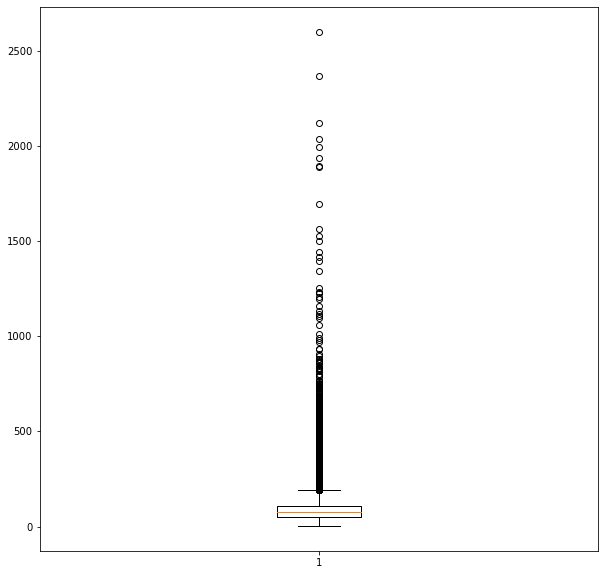

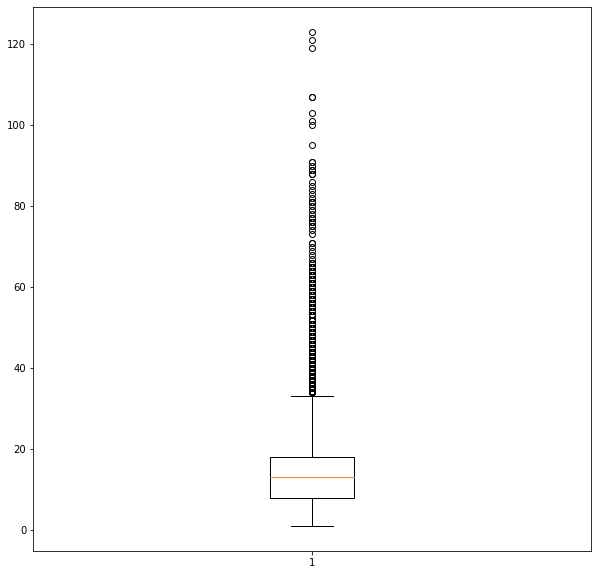

In [68]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plt.boxplot(traindata.textlenafter)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
plt.boxplot(traindata.word_countafter)
plt.show()

In [70]:
#### There is many outlier, let's check and drop them
traindata[traindata['word_countafter']>40]
traindata=traindata.drop(traindata[(traindata.word_countafter>70)].index)

## Wordcloud Visualization

see the word frequency for every emotion

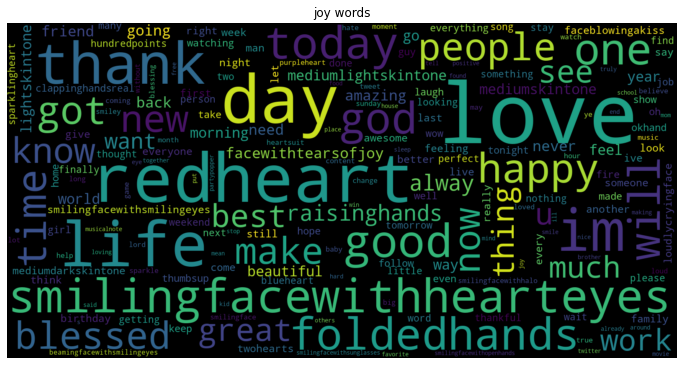

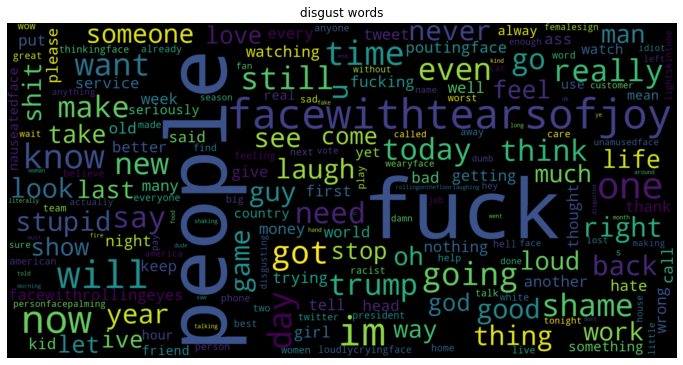

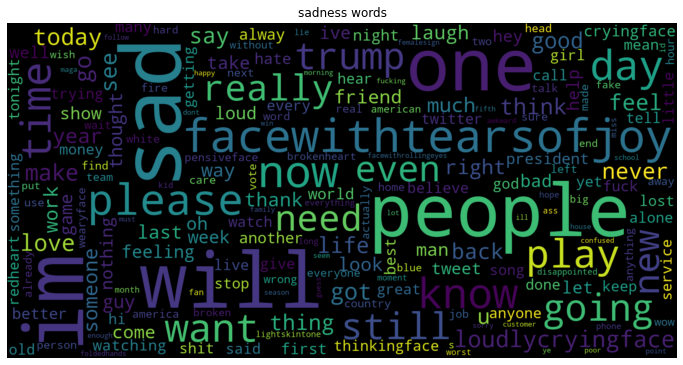

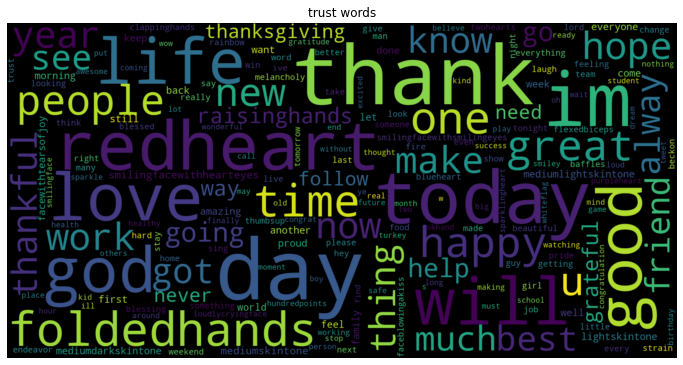

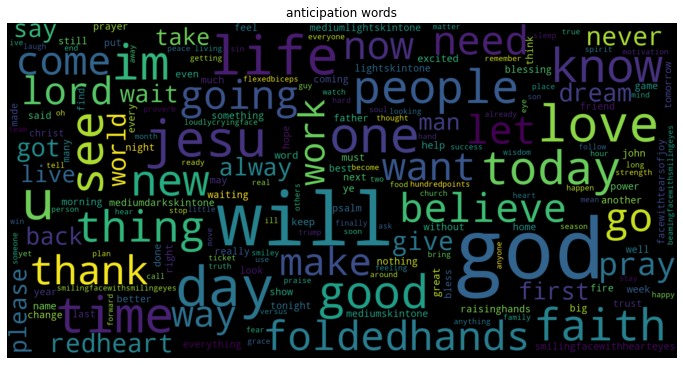

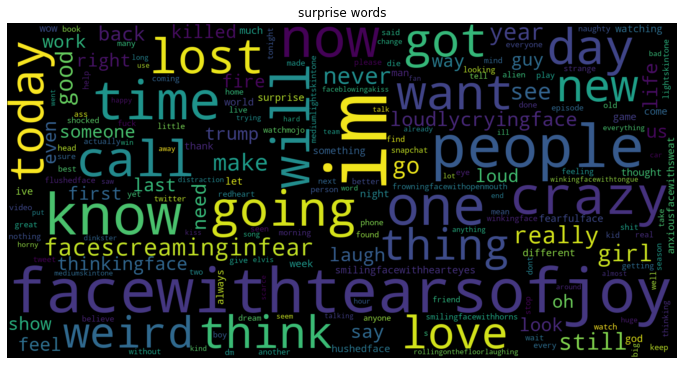

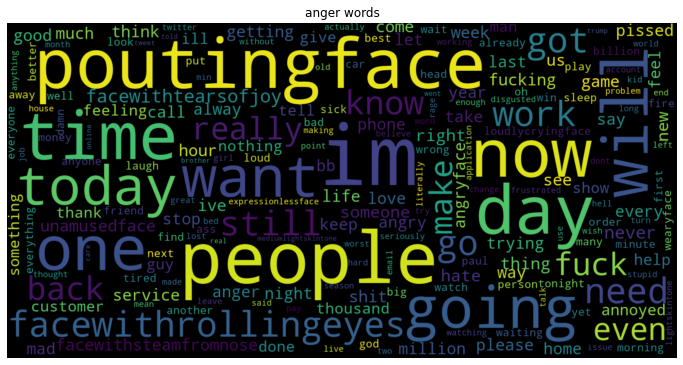

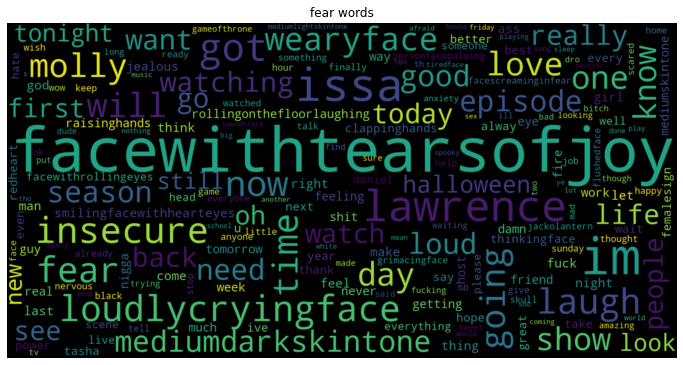

In [71]:
# conda install -c conda-forge wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud
joy_tweets = traindata[traindata.emotion == 'joy']
joy_string = []
for t in joy_tweets.cleantext:
    joy_string.append(t)
joy_string = pd.Series(joy_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(joy_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("joy words")
plt.show()

disgust_tweets = traindata[traindata.emotion == 'disgust']
disgust_string = []
for t in disgust_tweets.cleantext:
    disgust_string.append(t)
disgust_string = pd.Series(disgust_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(disgust_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("disgust words")
plt.show()

sadness_tweets = traindata[traindata.emotion == 'sadness']
sadness_string = []
for t in sadness_tweets.cleantext:
    sadness_string.append(t)
sadness_string = pd.Series(sadness_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(sadness_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("sadness words")
plt.show()

trust_tweets = traindata[traindata.emotion == 'trust']
trust_string = []
for t in trust_tweets.cleantext:
    trust_string.append(t)
trust_string = pd.Series(trust_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(trust_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("trust words")
plt.show()

anticipation_tweets = traindata[traindata.emotion == 'anticipation']
anticipation_string = []
for t in anticipation_tweets.cleantext:
    anticipation_string.append(t)
anticipation_string = pd.Series(anticipation_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(anticipation_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("anticipation words")
plt.show()

surprise_tweets = traindata[traindata.emotion == 'surprise']
surprise_string = []
for t in surprise_tweets.cleantext:
    surprise_string.append(t)
surprise_string = pd.Series(surprise_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(surprise_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("surprise words")
plt.show()

anger_tweets = traindata[traindata.emotion == 'anger']
anger_string = []
for t in anger_tweets.cleantext:
    anger_string.append(t)
anger_string = pd.Series(anger_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(anger_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("anger words")
plt.show()

fear_tweets = traindata[traindata.emotion == 'fear']
fear_string = []
for t in fear_tweets.cleantext:
    fear_string.append(t)
fear_string = pd.Series(fear_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(fear_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("fear words")
plt.show()

In [72]:
#drop text that have less than 2 words and texlen morethan 50
traindata=traindata.drop(traindata[(traindata.word_countafter<3)& (traindata.textlenafter > 50)].index)

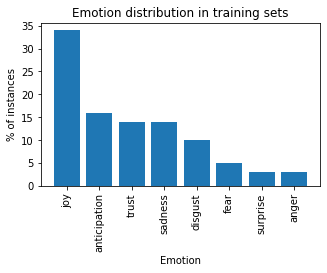

In [73]:
#check the distribution between each emotion
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = traindata['emotion'].unique()
post_total = len(traindata)
df1 = traindata['emotion'].value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution in training sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

### Because the data is highly imbalance, it need to do some operation

# 2. Feature engineering

In [74]:
#split the data for training and testing the model
from sklearn.model_selection import train_test_split
X = traindata.cleantext
y = traindata.emotion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

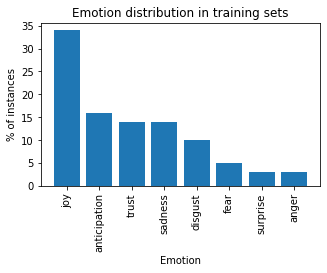

In [75]:
#see the distribution between each emotion
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = y_train.unique()
post_total = len(y_train)
df1 = y_train.value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution in training sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

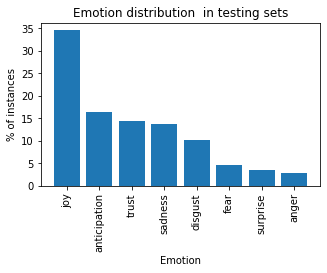

In [103]:
# the histogram of the data
labels = y_test.unique()
post_total = len(y_test)
df1 = y_test.value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution  in testing sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

## 2.1 Bag of word (countvectorizer)

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
BOW_vectorizer = CountVectorizer(stop_words='english') 
BOW_vectorizer.fit(X_train)
train_data_vectorizer_features=BOW_vectorizer.transform(X_train)

## 2.2 Tfidfvertorizer

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidfvertorizer = TfidfVectorizer(stop_words = "english")
train_data_Tfidf_features = Tfidfvertorizer.fit_transform(X_train)

## 2.3 nltktokenizer

In [78]:
from nltk.tokenize import  word_tokenize
word_tokenize = CountVectorizer(tokenizer = word_tokenize,stop_words='english')
train_data_tweet_features = word_tokenize.fit_transform(X_train)

## 2.4 other tokenizer

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import (TreebankWordTokenizer,
                           word_tokenize,
                           wordpunct_tokenize,
                           TweetTokenizer,
                           MWETokenizer)
wordpuncttokenize = CountVectorizer(tokenizer = wordpunct_tokenize,stop_words='english')
train_data_wordpuncttokenize_features = wordpuncttokenize.fit_transform(X_train)




# 3 Model&Evaluation

## 3.1 Naive Bayes Classifier

Naive Bayes (NB) is a common model for document classification. The main concept of Naive Bayes is to use the Bayes’ Theorem to estimate the joint probability of all the different words conditioned on each label.
Based on Homework2 experience, I use MultinomialNB as main model because it is the best one in three models

In [86]:
allemo = ['joy','sadness','trust','anticipation','disgust','surprise','anger','fear']

In [87]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion


In [88]:
%%time
# Use Bag of word (countvectorizer) + MultinomialNB Model
from sklearn.naive_bayes import MultinomialNB
nb_BOW = Pipeline([('vect', BOW_vectorizer),
               ('clf', MultinomialNB()),
              ])
nb_BOW.fit(X_train, y_train)


y_pred = nb_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))
#accuracy 0.5011942482922064

accuracy 0.5011942482922064
              precision    recall  f1-score   support

         joy       0.81      0.07      0.12      7413
     sadness       0.58      0.46      0.51     44251
       trust       0.45      0.34      0.39     27482
anticipation       0.79      0.23      0.36     12441
     disgust       0.49      0.82      0.62     92849
    surprise       0.43      0.44      0.44     36944
       anger       0.79      0.10      0.18      9514
        fear       0.55      0.22      0.31     38313

    accuracy                           0.50    269207
   macro avg       0.61      0.33      0.37    269207
weighted avg       0.54      0.50      0.47    269207

CPU times: total: 29.4 s
Wall time: 29.4 s


In [89]:
PRED= nb_BOW.predict(Testdata['cleantext'])

In [90]:
Testdata['emotion']=PRED

In [91]:
Testdata

,id,identification,text,textlen,word_count,cleantext,emotion
380015,0x2e0788,test,@reggiewatts You're a great inspiration to all man kind. <LH>,61,10,you are a great inspiration to all man kind,joy
95768,0x25ff0a,test,Such a busy weekend planned with so many activities & I cannot wait !! Roll on 5 o'clock on Friday <LH> 🎪👏🏼🍹💑💃🏽,111,22,such a busy weekend planned with so many activities i cannot wait roll on oclock on friday circustent clappinghands mediumlightskintone tropicaldrink couplewithheart womandancing mediumskintone,joy
37036,0x33a500,test,@aorosz12 and I just traded cars Bc she misses driving her Kia <LH>,67,13,and i just traded cars bc she misses driving her kia,disgust
14367,0x1ca130,test,i had an hour and a half meeting with my professor today and the only reason i made it home safe was because of her <LH>,120,26,i had an hour and a half meeting with my professor today and the only reason i made it home safe was because of her,joy
226409,0x238628,test,It's all about getting the bag now nothing else matters <LH>,60,11,it is all about getting the bag now nothing else matters,joy
...,...,...,...,...,...,...,...
84323,0x38e13a,test,Arrived home in less than an hour ☺ <LH>,40,9,arrived home in less than an hour smilingface,joy
397853,0x29a31b,test,Despite the set back things has still been coming together for me all weekend <LH>,82,15,despite the set back things has still been coming together for me all weekend,joy
181426,0x2a8416,test,"Thanks for the retweets and mentions, I will be doing a bunch this weekend =) #gratitude <LH> <LH>",98,18,thanks for the retweets and mentions i will be doing a bunch this weekend smiley gratitude,joy
76245,0x2c464d,test,Nothing better than ‘waking up naked’ from a concussion and hearing Sachi and Matsu come upstairs 🤒☹️ <LH>,106,18,nothing better than waking up naked from a concussion and hearing sachi and matsu come upstairs facewiththermometer frowningface,joy


In [113]:
Testdata[['id','emotion']].to_csv('NB_BOW.csv', sep=',', encoding='utf-8')

In [93]:
# Use TfidfVectorizer + MultinomialNB Model

#%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb_tfidf = Pipeline([('vect', Tfidfvertorizer),
               ('clf', MultinomialNB()),
              ])
nb_tfidf.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb_tfidf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))
#accuracy 0.44340228894493827

accuracy 0.44340228894493827
              precision    recall  f1-score   support

         joy       0.99      0.04      0.07      7413
     sadness       0.70      0.29      0.41     44251
       trust       0.62      0.11      0.19     27482
anticipation       0.97      0.09      0.17     12441
     disgust       0.40      0.96      0.57     92849
    surprise       0.51      0.26      0.34     36944
       anger       0.99      0.07      0.13      9514
        fear       0.76      0.08      0.14     38313

    accuracy                           0.44    269207
   macro avg       0.74      0.24      0.25    269207
weighted avg       0.60      0.44      0.36    269207



In [ ]:
PRED= nb_word.predict(Testdata['cleantext'])

In [ ]:
Testdata['emotion']=PRED

In [ ]:
Testdata[['id','emotion']].to_csv('NB_WORD.csv', sep=',', encoding='utf-8')

In [94]:
# Use nltktokenizer.wordpuncttokenize + MultinomialNB Model
# With the help of nltk.tokenize.WordPunctTokenizer()() method, we are able to extract the tokens from string of words or 
#sentences in the form of Alphabetic and Non-Alphabetic character by using tokenize.WordPunctTokenizer()() method.

#%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize),
               ('clf', MultinomialNB()),
              ])
nb_wordpuncttokenize.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))
#accuracy  0.5012091067468528


accuracy 0.5012091067468528
              precision    recall  f1-score   support

         joy       0.81      0.07      0.12      7413
     sadness       0.58      0.46      0.51     44251
       trust       0.45      0.34      0.39     27482
anticipation       0.79      0.23      0.35     12441
     disgust       0.49      0.82      0.62     92849
    surprise       0.44      0.44      0.44     36944
       anger       0.79      0.10      0.18      9514
        fear       0.55      0.22      0.31     38313

    accuracy                           0.50    269207
   macro avg       0.61      0.33      0.37    269207
weighted avg       0.54      0.50      0.47    269207



In [ ]:
PRED= nb_wordpuncttokenize.predict(Testdata['cleantext'])

In [ ]:
Testdata['emotion']=PRED

In [ ]:
Testdata[['id','emotion']].to_csv('NB_wordpuncttokenize.csv', sep=',', encoding='utf-8')

In [97]:
###  wordpuncttokenize+ MultinomialNB Model is best
### after trying every tokenizer I found that countvect with default Bag of word gave me the best resut so I use it



# 3.2 SGDClassifier

In [98]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

sgd_wordpuncttokenize = Pipeline([('vect',  wordpuncttokenize),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd_wordpuncttokenize.fit(X_train, y_train)



y_pred = sgd_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

accuracy 0.48711586251471917
              precision    recall  f1-score   support

         joy       0.40      0.18      0.25      7413
     sadness       0.50      0.46      0.48     44251
       trust       0.46      0.31      0.37     27482
anticipation       0.55      0.31      0.39     12441
     disgust       0.49      0.81      0.61     92849
    surprise       0.46      0.35      0.40     36944
       anger       0.39      0.17      0.23      9514
        fear       0.48      0.18      0.26     38313

    accuracy                           0.49    269207
   macro avg       0.47      0.35      0.38    269207
weighted avg       0.48      0.49      0.45    269207

CPU times: total: 1min 4s
Wall time: 54.1 s


In [99]:
%%time
from sklearn.linear_model import SGDClassifier
#CountVectorizer(stop_words='english')
sgd_BOW = Pipeline([('vect', BOW_vectorizer),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd_BOW.fit(X_train, y_train)



y_pred = sgd_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

accuracy 0.48722730092456734
              precision    recall  f1-score   support

         joy       0.38      0.19      0.25      7413
     sadness       0.51      0.46      0.48     44251
       trust       0.46      0.31      0.37     27482
anticipation       0.56      0.31      0.40     12441
     disgust       0.49      0.81      0.61     92849
    surprise       0.47      0.35      0.40     36944
       anger       0.39      0.17      0.23      9514
        fear       0.48      0.18      0.26     38313

    accuracy                           0.49    269207
   macro avg       0.47      0.35      0.38    269207
weighted avg       0.48      0.49      0.45    269207

CPU times: total: 1min 1s
Wall time: 52 s


In [ ]:
# The wordpuncttokenize+ SGDClassifier is not better than wordpuncttokenize+ MultinomialNB Model

--------------------------------------------

# 3.3 LogisticRegression

In [102]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
#CountVectorizer(stop_words='english')
logreg_BOW = Pipeline([('vect', BOW_vectorizer),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg_BOW.fit(X_train, y_train)



y_pred = logreg_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

D:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.5025909430289702
              precision    recall  f1-score   support

         joy       0.45      0.20      0.27      7413
     sadness       0.57      0.45      0.50     44251
       trust       0.44      0.36      0.40     27482
anticipation       0.64      0.32      0.43     12441
     disgust       0.50      0.79      0.61     92849
    surprise       0.46      0.39      0.42     36944
       anger       0.50      0.19      0.28      9514
        fear       0.50      0.27      0.35     38313

    accuracy                           0.50    269207
   macro avg       0.51      0.37      0.41    269207
weighted avg       0.50      0.50      0.48    269207

CPU times: total: 8min 43s
Wall time: 2min 49s


In [ ]:
PRED= logreg_BOW.predict(Testdata['cleantext'])

In [ ]:
Testdata['emotion']=PRED

In [ ]:
Testdata[['id','emotion']].to_csv('LR_BOW.csv', sep=',', encoding='utf-8')

In [103]:
%%time
from sklearn.linear_model import LogisticRegression

logreg_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize),('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg_wordpuncttokenize.fit(X_train, y_train)



y_pred = logreg_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 
#accuracy 0.5060473685774568


D:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.489333486870698
              precision    recall  f1-score   support

         joy       0.55      0.13      0.21      7413
     sadness       0.57      0.43      0.49     44251
       trust       0.44      0.31      0.36     27482
anticipation       0.69      0.29      0.40     12441
     disgust       0.47      0.83      0.60     92849
    surprise       0.45      0.39      0.42     36944
       anger       0.55      0.14      0.22      9514
        fear       0.55      0.19      0.28     38313

    accuracy                           0.49    269207
   macro avg       0.53      0.34      0.37    269207
weighted avg       0.51      0.49      0.45    269207

CPU times: total: 8min 33s
Wall time: 2min 47s


In [ ]:
#the best one is  LogisticRegression + wordpuncttokenize

## 3.4 CNN

In [114]:
#I replace old keras to new onw(tensorflow keras)
# 
#from keras.models import Model
#from keras.layers import Input, Dense
#from keras.layers import ReLU, Softmax

import tensorflow as tf 
keras = tf.keras

from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Reshape, Dropout, Dense,Multiply, Dot, Concatenate,Embedding,ReLU, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
import nltk

# build analyzers (bag-of-words)
BOW_500_word_tokenize = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 


# apply analyzer to training data
BOW_500_word_tokenize.fit(traindata['cleantext'])

train_data_BOW_features_500 = BOW_500_word_tokenize.transform(traindata['cleantext'])


In [115]:
import nltk

#wordpunct_tokenize
BOW_500_wordpunct_tokenize = CountVectorizer(max_features=500, tokenizer=nltk.wordpunct_tokenize) 


# apply analyzer to training data
BOW_500_wordpunct_tokenize.fit(traindata['cleantext'])

train_data_wordpunctfeatures_500 = BOW_500_wordpunct_tokenize.transform(traindata['cleantext'])


D:\ProgramData\anaconda3\envs\env1\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [116]:
# standardize name (X, y) 
X_train = BOW_500_wordpunct_tokenize.transform(traindata['cleantext'])
y_train = traindata['emotion']

X_test = BOW_500_wordpunct_tokenize.transform(Testdata['cleantext'])
y_test = Testdata['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1346032, 500)
y_train.shape:  (1346032,)
X_test.shape:  (411972, 500)
y_test.shape:  (411972,)


In [117]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 615514     disgust
253841       trust
1173442      trust
1001718      trust
Name: emotion, dtype: object

y_train.shape:  (1346032,)
y_test.shape:  (411972,)


## After convert
y_train[0:4]:
 [[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

y_train.shape:  (1346032, 8)
y_test.shape:  (411972, 8)


In [118]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  8


In [132]:

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=256)(X)  # 64
H1 = ReLU()(X_W1)
H1 = Dropout(0.2)(H1)

# 2nd hidden layer
H1_W2 = Dense(units=128)(H1)  # 64
H2 = ReLU()(H1_W2)
H2 = Dropout(0.2)(H2)


# 2nd hidden layer
H3 = Dense(units=64)(H2)  # 64
H3 = ReLU()(H3)
H3 = Dropout(0.2)(H3)


# 2nd hidden layer
H4 = Dense(units=32)(H3)  # 64
H4 = ReLU()(H4)
H4 = Dropout(0.2)(H4)


# output layer
H5 = Dense(units=output_shape)(H4)  # 4

H5 = Softmax()(H5)

model_output = H5

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_14 (Dense)            (None, 256)               128256    
                                                                 
 re_lu_11 (ReLU)             (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 re_lu_12 (ReLU)             (None, 128)               0         
                                                                 
 dropout_8 (Dropout)         (None, 128)               0   

In [133]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log.csv')

# training setting
epochs = 10
batch_size = 128

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/10


D:\ProgramData\anaconda3\envs\env1\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/dense_14/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/dense_14/embedding_lookup_sparse/Reshape:0", shape=(None, 256), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/dense_14/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


10516/10516 [==============================] - 115s 11ms/step - loss: 1.5788 - accuracy: 0.4213 - val_loss: 1.2520 - val_accuracy: 0.6021
Epoch 2/10
10516/10516 [==============================] - 144s 13ms/step - loss: 1.5332 - accuracy: 0.4389 - val_loss: 1.2526 - val_accuracy: 0.5949
Epoch 3/10
10516/10516 [==============================] - 185s 17ms/step - loss: 1.5192 - accuracy: 0.4443 - val_loss: 1.2548 - val_accuracy: 0.5821
Epoch 4/10
10516/10516 [==============================] - 185s 17ms/step - loss: 1.5111 - accuracy: 0.4482 - val_loss: 1.2451 - val_accuracy: 0.5873
Epoch 5/10
10516/10516 [==============================] - 185s 17ms/step - loss: 1.5045 - accuracy: 0.4508 - val_loss: 1.2534 - val_accuracy: 0.5822
Epoch 6/10
10516/10516 [==============================] - 197s 18ms/step - loss: 1.4998 - accuracy: 0.4527 - val_loss: 1.2430 - val_accuracy: 0.5872
Epoch 7/10
10516/10516 [==============================] - 200s 19ms/step - loss: 1.4959 - accuracy: 0.4544 - val_loss

In [143]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

TypeError: predict() got an unexpected keyword argument 'batch_size'

In [ ]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

In [ ]:
Testdata['emotion']=pred_result

In [ ]:
Testdata[['id','emotion']].to_csv('CNN2.csv', sep=',', encoding='utf-8')

# 3.4 RandomForestClassifier

In [105]:
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfTransformer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                      ('mnb', MultinomialNB(fit_prior=False)), 
                            ])
text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)
y_pred = text_mnb_stemmed.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LEOLIN_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


accuracy 0.4868781272403764
              precision    recall  f1-score   support

         joy       0.25      0.08      0.12      7413
     sadness       0.55      0.45      0.50     44251
       trust       0.44      0.31      0.36     27482
anticipation       0.69      0.25      0.36     12441
     disgust       0.49      0.79      0.60     92849
    surprise       0.43      0.43      0.43     36944
       anger       0.64      0.11      0.18      9514
        fear       0.51      0.21      0.30     38313

    accuracy                           0.49    269207
   macro avg       0.50      0.33      0.36    269207
weighted avg       0.50      0.49      0.45    269207



In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)


#Use pipeline to carry out steps in sequence with a single object
#SVM's rbf kernel gives highest accuracy in this classification problem.

#('vect', wordpuncttokenize)
#RF_CountVectorizer = Pipeline([('vect', CountVectorizer(stop_words='english')), ('clf', RandomForestClassifier())])
bag_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize), ('clf', bag)])
             
bag_wordpuncttokenize.fit(X_train, y_train)

y_pred = bag_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

In [ ]:
PRED= bag_wordpuncttokenize.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

#Testdata

Testdata[['id','emotion']].to_csv('BaggingClassifier_wordpuncttokenize.csv', sep=',', encoding='utf-8')

In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

RF_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize), ('clf', RandomForestClassifier())])

             
RF_wordpuncttokenize.fit(X_train, y_train)

y_pred = RF_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

In [ ]:
PRED= RF_wordpuncttokenize.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

#Testdata

Testdata[['id','emotion']].to_csv('RF_wordpuncttokenize.csv', sep=',', encoding='utf-8')

In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

#Use pipeline to carry out steps in sequence with a single object
#SVM's rbf kernel gives highest accuracy in this classification problem.

#('vect', wordpuncttokenize)
#RF_CountVectorizer = Pipeline([('vect', CountVectorizer(stop_words='english')), ('clf', RandomForestClassifier())])
#

RF_BOW_vectorizer = Pipeline([('vect', BOW_vectorizer), ('clf', RandomForestClassifier())])
             
RF_BOW_vectorizer.fit(X_train, y_train)

y_pred = RF_BOW_vectorizer.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

# 3.5 FASTTEXT(Best score)

Format data & export to TXT because fasttext read data from text file

In [134]:
hyper_params = {"lr": 0.01,
                "epoch": 14,
                "wordNgrams": 2,
                "dim": 20}    

In [135]:
traindata['data'] = traindata['cleantext']+'__label__'+traindata['emotion']

In [136]:
traindata['data'].to_csv('fastnotokay1.txt')

Trainmodel&evaluate

In [137]:
import fasttext

In [138]:
model = fasttext.train_supervised('fastnotokay1.txt',**hyper_params)
print("Model trained with the hyperparameter \n {}".format(hyper_params))

Model trained with the hyperparameter 
 {'lr': 0.01, 'epoch': 14, 'wordNgrams': 2, 'dim': 20}


In [139]:
traindata['cleantext'][1]

'yoo we hit all our monthly goals with the new application in two weeks spateradio application'

In [140]:
model.predict(traindata['cleantext'][1])

(('__label__joy',), array([0.32298666]))

Evaluate kaggle test dataset

In [141]:
Testdata['emotion'] = Testdata['cleantext'].apply(lambda x: model.predict(x))

In [142]:
Testdata[['id','emotion']].to_csv('FAST22ngram.csv', sep=',', encoding='utf-8')

------------------------------------------------

# Conclusion
## Insights gained.

- between these models I tried, I foud that  LogisticRegression+wordpuncttokenize  give me the best result on the competition with very fast training time 
- text from twitter are really messy so the text cleaning is very important (I go back many times to do the text cleaning)
- this case BOW is better than Tfidf, may be the frequent word is really help us to classify but idf removed it.(at first I think TFIDF would perform better)

# Things I want to improve/try

- other language models like bert(I've tried roberta but my computer keep dying & the estimated time train are 10 days ;(
- try upsampling/other method to deal with the data imbalance.Because the majority of the data labels are 'joy,' so the model may be difficult to predict other emotions.
- the spell check because text from social contain many typo (I've tried spellchecker/textblob but it took too long)
- too many repeated words in tweet text I found when i plot a boxplot, I wantto remove them.
- word2vec